In [108]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim

In [109]:
from matplotlib import pyplot as plt
from torchvision import utils
def imshow(inp, save=False, title=None):
    """Imshow for Tensor."""
    fig = plt.figure(figsize=(5, 5))
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp,cmap='gray')
    plt.show()

In [110]:
root = './data'
download = True
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5,), (0.5,0.5,0.5))])
train_set = dset.MNIST(root=root, train=True, transform=trans, download=download)
test_set = dset.MNIST(root=root, train=False, transform=trans)
batch_size = 128
kwargs = {}
train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)

In [111]:
z_size=128
hidden_size=128
img_size=28

In [116]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(z_size, hidden_size*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_size*2, hidden_size*4),
            nn.LeakyReLU(0.2, inplace=True),
#             nn.Linear(hidden_size*4, hidden_size*8),
#             nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_size*4, img_size**2),
            nn.Tanh()
        )
    def forward(self, x):
        x = x.view(x.size()[0], z_size)
        out = self.model(x)
        out = out.view(x.size()[0], 1,img_size,img_size)
        return out

In [117]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(img_size**2, hidden_size*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
#             nn.Linear(hidden_size*8, hidden_size*4),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Dropout(0.3),
            nn.Linear(hidden_size*4, hidden_size*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(hidden_size*2, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        out = self.model(x.view(x.size(0), img_size**2))
        out = out.view(out.size(0), -1)
        return out

  0%|          | 0/10001 [00:00<?, ?it/s]

-1.0
-0.44902658462524414
torch.Size([3, 62, 242])


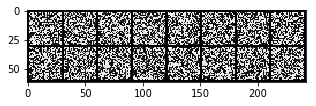

 10%|▉         | 1000/10001 [02:07<19:05,  7.86it/s]

-1.0
-1.0
torch.Size([3, 62, 242])


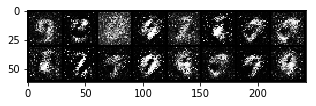

 20%|█▉        | 2000/10001 [04:11<16:44,  7.96it/s]

-1.0
-1.0
torch.Size([3, 62, 242])


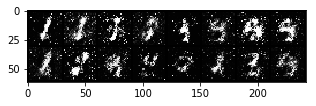

 30%|██▉       | 3000/10001 [06:28<15:07,  7.71it/s]

-1.0
-1.0
torch.Size([3, 62, 242])


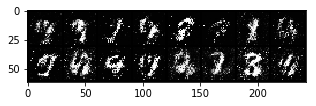

 40%|███▉      | 4000/10001 [08:26<12:40,  7.89it/s]

-1.0
-1.0
torch.Size([3, 62, 242])


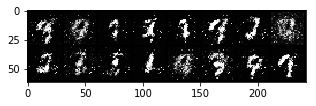

 50%|████▉     | 5000/10001 [10:36<10:36,  7.86it/s]

-1.0
-1.0
torch.Size([3, 62, 242])


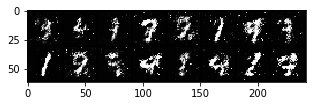

 60%|█████▉    | 6000/10001 [12:53<08:35,  7.76it/s]

-1.0
-1.0
torch.Size([3, 62, 242])


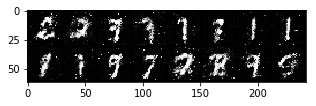

 70%|██████▉   | 7000/10001 [15:15<06:32,  7.65it/s]

-1.0
-1.0
torch.Size([3, 62, 242])


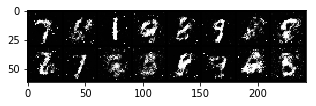

 80%|███████▉  | 8000/10001 [17:31<04:23,  7.61it/s]

-1.0
-1.0
torch.Size([3, 62, 242])


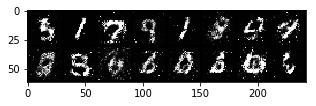

 90%|████████▉ | 9000/10001 [19:26<02:09,  7.72it/s]

-1.0
-1.0
torch.Size([3, 62, 242])


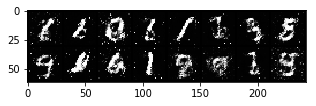

100%|█████████▉| 10000/10001 [21:45<00:00,  7.66it/s]

-1.0
-1.0
torch.Size([3, 62, 242])


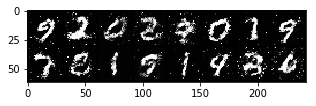

100%|██████████| 10001/10001 [21:45<00:00,  7.66it/s]


In [118]:
from tqdm import tqdm
G = Generator()
D = Discriminator()
G_lr = D_lr = 0.0002
optimizers = {
    'D': torch.optim.Adam(D.parameters(), lr=D_lr, betas=(0.5, 0.999)),
    'G': torch.optim.Adam(G.parameters(), lr=G_lr, betas=(0.5, 0.999))
}
criterion = nn.BCELoss()
for epoch in tqdm(range(10000+1)):
    data = next(iter(train_loader))[0]
    ones_label = Variable(torch.ones((data.size()[0], 1)))
    zeros_label = Variable(torch.zeros((data.size()[0], 1)))

    optimizers['D'].zero_grad()
    data = Variable(data)
    output_real = D(data)
    loss_real_G = criterion(output_real, ones_label)

    noisev = torch.randn(data.size()[0], z_size, 1, 1)
    noisev = Variable(noisev)
    fake_data = G(noisev)
    output_fake = D(fake_data)
    loss_fake_G = criterion(output_fake, zeros_label)

    loss_real = loss_real_G + loss_fake_G
    loss_real.backward()
    optimizers['D'].step()

    optimizers['G'].zero_grad()
    noisev = torch.randn(data.size()[0], z_size, 1, 1)
    noisev = Variable(noisev)
    fake_data = G(noisev)
    output_fake1 = D(fake_data)
    loss_fake_G = criterion(output_fake1, ones_label)
    loss_fake_G.backward()
    optimizers['G'].step()
    #     print(data[0])
    #     print('------------')
    #     print(fake_data[0])
    #     break

    if epoch % 1000 == 0:
        print(data.data.min())
        print(fake_data.data.min())
        dd = utils.make_grid(fake_data.data[:16])
        print(dd.size())
        imshow(dd)
#         dd = utils.make_grid(data.data[:16])
#         imshow(dd)